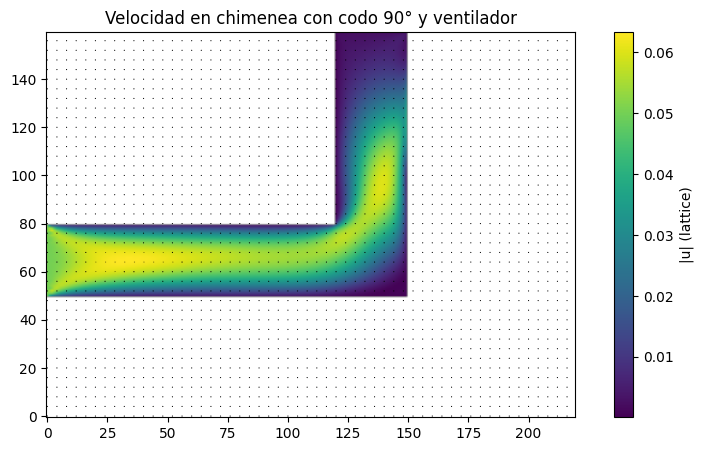

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------- LBM D2Q9 ----------------
c = np.array([[0,0],[1,0],[0,1],[-1,0],[0,-1],[1,1],[-1,1],[-1,-1],[1,-1]])
w = np.array([4/9,1/9,1/9,1/9,1/9,1/36,1/36,1/36,1/36])
opp = [0,3,4,1,2,7,8,5,6]

# Dominio y geometría (2D)
dx = 0.1             # 10 cm por celda
duct_diam = 3.0      # m
W = int(duct_diam/dx)
Nx, Ny = 220, 160
x_elbow, y_start = 120, 50

# Máscara de fluido (ducto en L)
fluid = np.zeros((Ny,Nx),dtype=bool)
fluid[y_start:y_start+W, 0:x_elbow] = True
fluid[y_start:Ny, x_elbow:x_elbow+W] = True

# Ventilador: zona de forzado en la rama vertical
fan_mask = np.zeros_like(fluid)
fan_mask[y_start+W+5:y_start+W+35, x_elbow:x_elbow+W] = True

# Parámetros LBM
tau = 0.62
omega = 1/tau
rho0 = 1.0
uin = 0.05   # velocidad de entrada (lattice units)
fan_force = 3e-5

# Inicialización
f = np.zeros((9,Ny,Nx))
for i in range(9):
    f[i] = rho0*w[i]
rho = np.ones((Ny,Nx))
ux = np.zeros((Ny,Nx)); uy = np.zeros((Ny,Nx))

# Funciones auxiliares
def equilibrium(rho,ux,uy):
    feq = np.zeros((9,Ny,Nx))
    u2 = ux**2+uy**2
    for i,(cx,cy) in enumerate(c):
        cu = 3*(cx*ux+cy*uy)
        feq[i] = w[i]*rho*(1+cu+0.5*cu**2-1.5*u2)
    return feq

def stream(f):
    for i,(cx,cy) in enumerate(c):
        f[i] = np.roll(np.roll(f[i], cx, 1), cy, 0)

def bounce_back(f):
    for i in range(9):
        f[i,~fluid] = f[opp[i],~fluid]

def macroscopic(f,Fx,Fy):
    rho = np.sum(f,axis=0)
    jx = np.sum(f*c[:,0][:,None,None],axis=0)
    jy = np.sum(f*c[:,1][:,None,None],axis=0)
    ux = (jx+0.5*Fx)/rho; uy = (jy+0.5*Fy)/rho
    return rho,ux,uy

def forcing(Fx,Fy,ux,uy):
    Fi = np.zeros_like(f)
    factor = (1-0.5/tau)
    for i,(cx,cy) in enumerate(c):
        euF = (cx-ux)*Fx+(cy-uy)*Fy
        eu = cx*ux+cy*uy; eF = cx*Fx+cy*Fy
        Fi[i] = w[i]*factor*(3*euF+9*eu*eF)
    return Fi

# Fuerza del ventilador
Fx = np.zeros((Ny,Nx)); Fy = np.zeros((Ny,Nx))
Fy[fan_mask] = fan_force

# Iteración LBM
for it in range(1200):
    rho,ux,uy = macroscopic(f,Fx,Fy)
    ux[~fluid]=0; uy[~fluid]=0
    feq = equilibrium(rho,ux,uy)
    Fi = forcing(Fx,Fy,ux,uy)
    f = (1-omega)*f+omega*feq+Fi
    stream(f)
    bounce_back(f)
    # Inlet con velocidad fija
    x=0; ys=slice(y_start,y_start+W)
    rho_bc = (f[0,ys,x]+f[2,ys,x]+f[4,ys,x]+2*(f[3,ys,x]+f[6,ys,x]+f[7,ys,x]))/(1-uin)
    f[1,ys,x]=f[3,ys,x]+2/3*rho_bc*uin
    f[5,ys,x]=f[7,ys,x]+0.5*(f[4,ys,x]-f[2,ys,x])+1/6*rho_bc*uin
    f[8,ys,x]=f[6,ys,x]+0.5*(f[2,ys,x]-f[4,ys,x])+1/6*rho_bc*uin

# Resultados finales
rho,ux,uy = macroscopic(f,Fx,Fy)
umag = np.sqrt(ux**2+uy**2); umag[~fluid]=np.nan

plt.figure(figsize=(10,5))
plt.imshow(umag,origin='lower',interpolation='bilinear')
plt.colorbar(label='|u| (lattice)')
Y,X=np.mgrid[0:Ny,0:Nx]
plt.quiver(X[::4,::4],Y[::4,::4],ux[::4,::4],uy[::4,::4],scale=25)
plt.title('Velocidad en chimenea con codo 90° y ventilador')
plt.show()


In [12]:
A=10.43     # m^2
Q=96*1000        # Kcfm
Q1 = Q * 0.0004719
v= Q1 / A
print(Q1)
print(v)



45.3024
4.343470757430489


In [13]:
import numpy as np

def generar_valores(v, n=9, variabilidad=0.08):
    # Rango permitido de variación
    rango_min = v * (1 - variabilidad)
    rango_max = v * (1 + variabilidad)

    # Generar n valores aleatorios dentro del rango
    valores = np.random.uniform(rango_min, rango_max, n)

    # Ajustar los valores para que su promedio sea exactamente v
    factor = v / valores.mean()
    valores_ajustados = valores * factor

    return np.round(valores_ajustados, 2)

# Ejemplo: si el usuario introduce v = 4.35
ejemplo_valores = generar_valores(4.35)
ejemplo_valores, ejemplo_valores.mean()


(array([4.2 , 4.63, 4.2 , 4.33, 4.62, 4.27, 4.  , 4.25, 4.65]),
 np.float64(4.35))